In [1]:
from PmtWaveForm import WaveForm
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


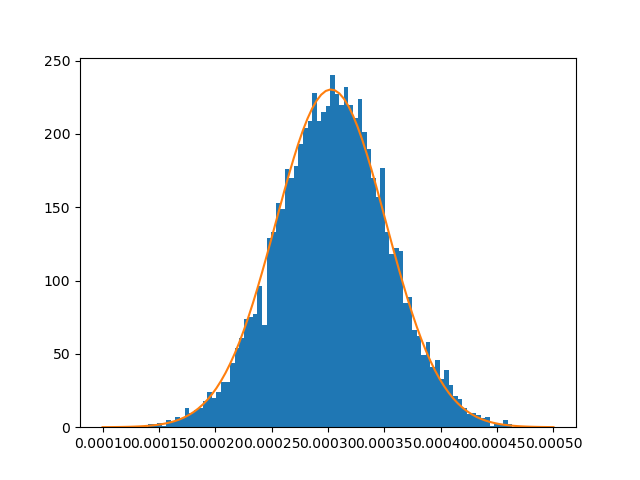

parameters: [2.30268046e+02 3.02587539e-04 4.89001204e-05]


In [2]:
# 基线分布
data = pd.read_csv("/run/media/einstein/Elements/CR160_data/1400V.csv")
bins = np.linspace(1e-4, 5e-4, 100)
f, a = plt.subplots()
content, b, _ = a.hist(data['pedestal'].to_numpy(), bins)
def fgauss(x, a, m, s):
    return a * np.exp(-(x-m)**2/(2*s**2))
fit_par, fit_cov = curve_fit(fgauss, b[:-1], content, [100, 0.0003, 0.0001])
print("parameters: {}".format(fit_par))
a.plot(bins, fgauss(bins, *fit_par))
plt.show()

In [3]:
filter_data = data[data["Q"] < -2e-11]
filter_data = filter_data[filter_data["Q"] > -6.8e-11]
filter_data

,File,Q,pedestal
8,/run/media/einstein/Elements/CR160_data/CR160_...,-3.606248e-11,0.000354
39,/run/media/einstein/Elements/CR160_data/CR160_...,-6.245831e-11,0.000250
45,/run/media/einstein/Elements/CR160_data/CR160_...,-2.483334e-11,0.000321
55,/run/media/einstein/Elements/CR160_data/CR160_...,-4.850001e-11,0.000286
70,/run/media/einstein/Elements/CR160_data/CR160_...,-5.966666e-11,0.000379
...,...,...,...
6939,/run/media/einstein/Elements/CR160_data/CR160_...,-2.745834e-11,0.000300
6953,/run/media/einstein/Elements/CR160_data/CR160_...,-4.229164e-11,0.000344
6983,/run/media/einstein/Elements/CR160_data/CR160_...,-3.127083e-11,0.000370
6998,/run/media/einstein/Elements/CR160_data/CR160_...,-4.347916e-11,0.000355


In [4]:
def extreme_cubic_fun(a, b, c, d):
    delta = 4*b**2 -12 * a * c
    if delta >= 0:
        l_zero = (-2 * b - np.sqrt(delta))/ (6*a)
        r_zero = (-2 *b + np.sqrt(delta))/(6*a)
        l_extreme  = np.polyval([a, b, c, d], l_zero)
        r_extreme = np.polyval([a, b, c, d], r_zero)
        return l_zero, r_zero, l_extreme, r_extreme
    else:
        return None

拟合参数 a: -1.5888042686376585e+21 | b: -642673087015761.8 | c: -86743553.17521982 | d: [-1.58880427e+21 -6.42673087e+14 -8.67435532e+07 -3.90789476e+00] 
root 90: (-1.3649571691274273e-07+8.040963835647738e-09j)
root 10: (-1.4134102869875548e-07+0j)
raise time: (4.845311786012751e-09+8.040963835647738e-09j)
R2: 0.90067245173627


<IPython.core.display.Javascript object>


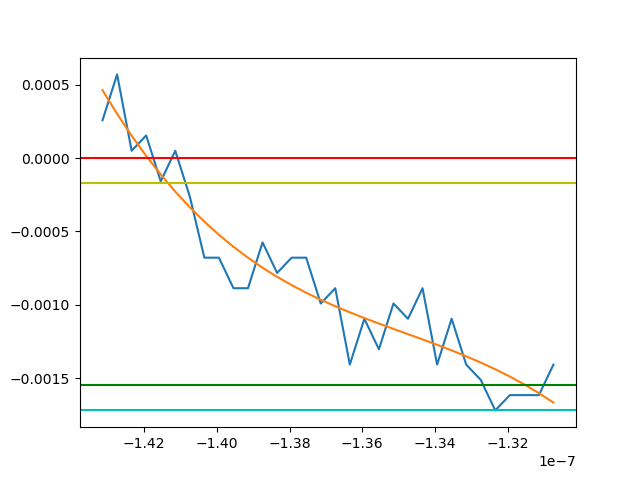

In [46]:
# 单文件测试
raise_data = pd.read_csv("raise_time.csv")
# wave = WaveForm.load_from_file(raise_data.loc[615, "File"])
# print("文件名称: {}".format(raise_data.loc[615, "File"]))
# wave = WaveForm.load_from_file(raise_data.loc[567, "File"])
# print("文件名称: {}".format(raise_data.loc[567, "File"]))
wave = WaveForm.load_from_file("/run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00468.csv")
# print("文件名称: {}".format(raise_data.loc[102, "File"]))
# ped = raise_data.loc[615, "pedestal"]
ped= 0
min_value, min_index = wave.min_ampl(-200e-9, 0)
max_index = min_index - 1
t = wave.get_time()
a = wave.get_ampl()
while True:
    if a[max_index] - ped > 0.1 * (min_value - ped):
        break
    else:
        max_index -= 1
lead_edge_t = t[max_index -5: min_index + 5]
lead_edge_a = a[max_index - 5: min_index + 5]
fit_par, residuals, rank, singular_values, rcond = np.polyfit(lead_edge_t, lead_edge_a, 3, full=True)
print("拟合参数 a: {} | b: {} | c: {} | d: {} ".format(fit_par[0], fit_par[1], fit_par[2], fit_par))
if extreme_cubic_fun(*fit_par) is not None and (lead_edge_t[0] < extreme_cubic_fun(*fit_par)[1] < lead_edge_t[-1]):
    poly_min_value = extreme_cubic_fun(*fit_par)[3]
else:
    poly_min_value = min_value
threshold90 = (poly_min_value - ped) * 0.9 + ped
threshold10 = (poly_min_value - ped) * 0.1 + ped
root90 = np.roots([fit_par[0], fit_par[1], fit_par[2], fit_par[3]-threshold90])
root10 = np.roots([fit_par[0], fit_par[1], fit_par[2], fit_par[3]-threshold10])
root90 = root90[root90 < lead_edge_t[-5]]
root90 = root90[root90 > lead_edge_t[0]]
print("root 90: {}".format(root90[0]))
root10 = root10[root10<lead_edge_t[-1]]
root10 = root10[root10>lead_edge_t[0]]
print("root 10: {}".format(root10[0]))
print("raise time: {}".format(root90[0] - root10[0]))
sst = np.var(lead_edge_a) * len(lead_edge_a)
r2 = 1 - residuals[0]/ sst
print("R2: {}".format(r2))
fig, ax = plt.subplots()
ax.plot(lead_edge_t, lead_edge_a)
ax.plot(lead_edge_t, WaveForm.cubic_fun(lead_edge_t, *fit_par))
ax.axhline(ped, color='r')
ax.axhline(threshold90, color='g')
ax.axhline(threshold10, color='y')
ax.axhline(poly_min_value, color='c')
plt.show()

<IPython.core.display.Javascript object>


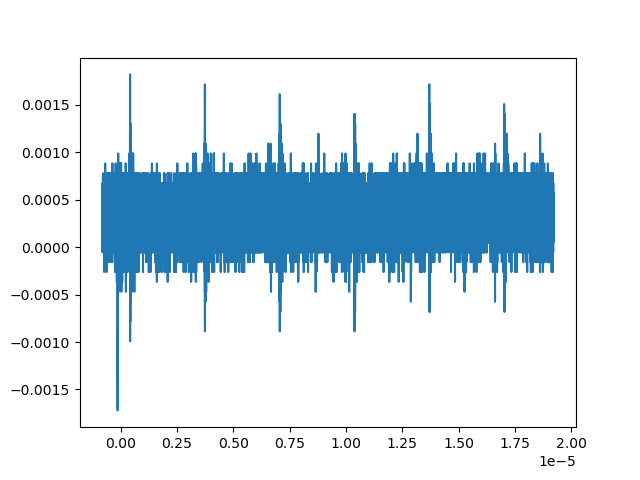

In [43]:
single_data = pd.read_csv("/run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00468.csv", header=4)
single_data
tmp_t = single_data["Time"]
tmp_a = single_data["Ampl"]
ff, aa = plt.subplots()
aa.plot(tmp_t, tmp_a)
plt.show()

In [59]:
# 循环测试
save_data = []
error_file = []
for i in range(len(filter_data)):
    print("文件名称: {}".format(filter_data.iloc[i, 0]))
    file_name = filter_data.iloc[i, 0]
    wave = WaveForm.load_from_file(file_name)
    ped = filter_data.iloc[i, 2]
    min_value, min_index = wave.min_ampl(-200e-9, 0)
    index10 = min_index - 1
    index90 = min_index-1
    t = wave.get_time()
    a = wave.get_ampl()
    while True:
        if a[index10] - ped > 0.1 * (min_value - ped):
            break
        else:
            index10 -= 1
    while True:
        if a[index90] - ped > 0.9 * (min_value - ped):
            break
        else:
            index90 -= 1
    # 线性拟合 or 直线拟合
    if False:
        lead_edge_t = t[index10 -5: min_index + 5]
        lead_edge_a = a[index10 - 5: min_index + 5]
        fit_par, residuals, rank, singular_values, rcond = np.polyfit(lead_edge_t, lead_edge_a, 3, full=True)
        # print("拟合参数 a: {} | b: {} | c: {} | d: {} ".format(fit_par[0], fit_par[1], fit_par[2], fit_par[3]))
        if extreme_cubic_fun(*fit_par) is not None and (lead_edge_t[0] < extreme_cubic_fun(*fit_par)[1] < lead_edge_t[-1]):
            poly_min_value = extreme_cubic_fun(*fit_par)[3]
        else:
            poly_min_value = min_value
        threshold90 = (poly_min_value - ped) * 0.9 + ped
        threshold10 = (poly_min_value - ped) * 0.1 + ped
        root90 = np.roots([fit_par[0], fit_par[1], fit_par[2], fit_par[3]-threshold90])
        root10 = np.roots([fit_par[0], fit_par[1], fit_par[2], fit_par[3]-threshold10])
        # 筛选与90% , 10%分界线焦点的横座标（时间座标）是否在拟合区间内
        root90 = root90[root90 < lead_edge_t[-5]]
        root90 = root90[root90 > lead_edge_t[0]]
        root10 = root10[root10<lead_edge_t[-1]]
        root10 = root10[root10>lead_edge_t[0]]
#     print("type root90: {}".format(type(root90[0])))
    else:
        lead_edge_t = t[index10: index90]
        lead_edge_a = a[index10: index90]
        fit_par, residuals, rank, singular_values, rcond = np.polyfit(lead_edge_t, lead_edge_a, 1, full=True)
        # print("拟合参数 a: {} | b: {} | c: {} | d: {} ".format(fit_par[0], fit_par[1], fit_par[2], fit_par[3]))
        poly_min_value = min_value
        threshold90 = (poly_min_value - ped) * 0.9 + ped
        threshold10 = (poly_min_value - ped) * 0.1 + ped
        root90 = np.roots([fit_par[0], fit_par[1]-threshold90])
        root10 = np.roots([fit_par[0], fit_par[1]-threshold10])
    try:
        raise_time = root90[0] - root10[0]
        # 在三次拟合中会出现复数根， 需要筛去复数根
        if isinstance(raise_time, np.complex128):
            error_file.append(file_name)
            raise_time = np.nan
    except IndexError:
        error_file.append(file_name)
        raise_time = np.nan
    sst = np.var(lead_edge_a) * len(lead_edge_a)
    r2 = 1 - residuals[0]/ sst
    # print("R2: {}".format(r2))
    if len(fit_par) == 4:
        row = [file_name, filter_data.iloc[i, 1], ped, *fit_par, index10 - 5, min_index + 5, raise_time, r2]
    else:
        row = [file_name, filter_data.iloc[i, 1], ped, *fit_par, index10 , index90, raise_time, r2]
    save_data.append(row)
# 判断拟合模型是三次还是线性，决定输出文件columns列内容
if False:
    my_data = pd.DataFrame(save_data, columns=["File", "Q", "pedestal", "a", "b", "c", "d", "lead_index1", "lead_index2", "raise_time" ,"r2"])
else:
    my_data = pd.DataFrame(save_data, columns=["File", "Q", "pedestal", "a", "b", "lead_index1", "lead_index2", "raise_time" ,"r2"])
my_data.to_csv("raise_time.csv", index = False)

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00007.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00040.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00046.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00118.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00057.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00061.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00071.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00120.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00893.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00914.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00938.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00949.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00959.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00962.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00975.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00996.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01790.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01791.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01804.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01822.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01830.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01831.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01849.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--01851.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02784.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02787.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02804.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02821.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02838.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02940.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02791.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--02811.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03643.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03646.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03674.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03690.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03695.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03712.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03714.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--03723.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04409.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04410.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04441.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04448.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04464.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04475.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04478.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--04495.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05174.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05213.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05220.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05229.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05231.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05232.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05266.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--05285.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06103.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06113.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06133.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06135.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06159.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06162.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06188.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06196.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06775.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06777.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06786.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06796.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06826.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06856.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06857.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--06864.csv
文件名称: /run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_Syn

422


<IPython.core.display.Javascript object>


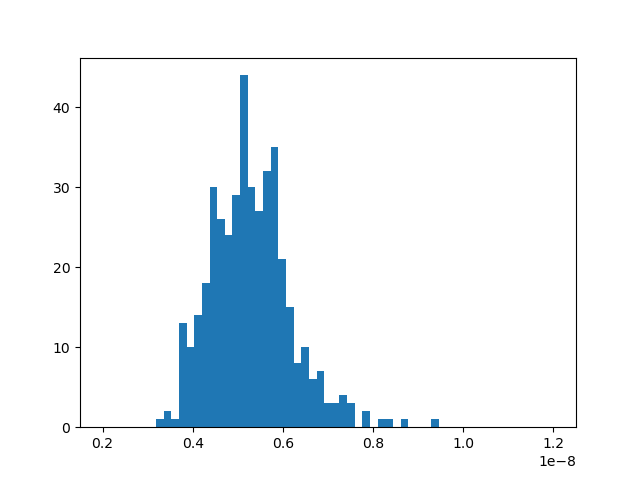

In [60]:
raise_data = pd.read_csv("raise_time.csv")
filter_raise_data = raise_data[raise_data["r2"]>0.95]
print(len(filter_raise_data))
f, a = plt.subplots()
a.hist(filter_raise_data["raise_time"].to_numpy(), np.linspace(2e-9, 12e-9, 60))
plt.show()

In [65]:
raise_data.iloc[0, 0]

'/run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00007.csv'

In [76]:
# 展示单文件拟合结果
raise_data = pd.read_csv("raise_time.csv")
def show_data_and_fit(file: str, expend: int = 0):
    select_row = raise_data[raise_data["File"] == file]
    lead1 = int(select_row["lead_index1"])
    lead2 = int(select_row["lead_index2"])
    wave = WaveForm.load_from_file(file)
    tmp_t = wave.get_time()
    tmp_a = wave.get_ampl()
    f, a = plt.subplots()
    a.plot(tmp_t[lead1-expend: lead2+expend], tmp_a[lead1-expend: lead2 + expend])
    if len(raise_data.columns) == 9:
        a.plot(tmp_t[lead1: lead2], np.polyval([select_row["a"], select_row["b"]], tmp_t[lead1: lead2]))
    else:
        a.plot(tmp_t[lead1: lead2], np.polyval([select_row["a"], select_row["b"], select_row["c"], select_row["d"]], tmp_t[lead1: lead2]))
    plt.show()

<IPython.core.display.Javascript object>


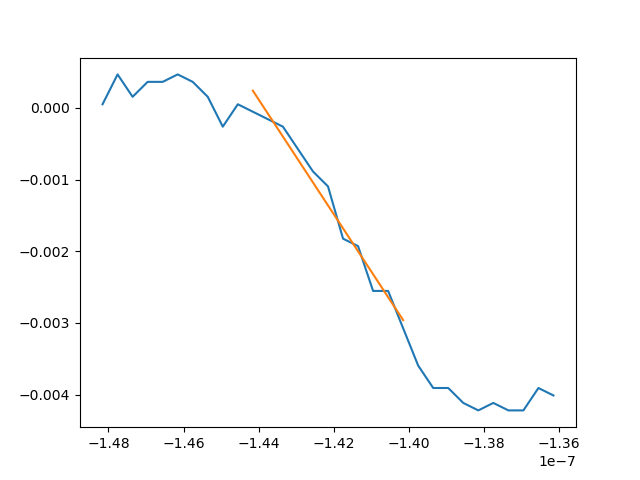

In [77]:
show_data_and_fit("/run/media/einstein/Elements/CR160_data/CR160_-1400V_LED_3.7V_1kHz_29.8ns_20us_SyncTrigger/C4--w--00007.csv", 10)